# Neural Networks for sentiment analysis

This notebook is the fourth part of the project. The reviews analysis was carried out in the `data_analysis.ipynb` notebook. Here only neural networks were tested for determining the sentiment of a review. The models were build using three kinds of layers:
 - Embedding (using pretrained _Glove_ word embeddings)
 - Bidirectional LSTM layer
 - Dense layer

__Reminder__ This classification problem is considered as imbalanced (almost 93% of the reviews are positive)

On the whole four approaches were tested:

 __1. Binary classification__<br>
 Only positive and negative reviews were taken into account
 - 1.1. Fitting model without any operations with regard to imlabance
 - 1.2. Usage of sample weight parameters in model fitting
 
__2. Multiclass classification__<br>
 All kinds of reviews were taken into account (positive, negative, neutral)
 - 2.1. Fitting model without any operations with regard to imlabance
 - 2.2. Usage of sample weight parameters in model fitting

__Loading libraries__

In [40]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, plot_roc_curve, roc_curve, classification_report
import os
import matplotlib.pyplot as plt
from datetime import date

In [41]:
from keras.layers import Embedding, Flatten, Dense, Bidirectional, LSTM
from keras import preprocessing
from keras.models import Sequential
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras.models import load_model

In [42]:
pd.set_option("max_colwidth", 1000)

__Loading the dataset__

In [43]:
data = pd.read_csv('Data_NN.csv', index_col='Unnamed: 0')

## Loading the pretrained word embeddings

In [44]:
#available dimensions: 50, 100, 200, 300
embedding_dim = 300
#how many top words will be considered
max_words=10000

#loading pretrained word embeddings
dir_ = 'glove'
embeddings_index = {}
f = open(os.path.join(dir_, f'glove.6B.{embedding_dim}d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

## 1. Binary Case

In [45]:
data_preprocessed_binary = data[data.rating != 3]

In [46]:
#changing pandas reviews to list 
X = data_preprocessed_binary.review.values.tolist()
y = data_preprocessed_binary.loc[:, 'rating'].astype('float32').values

In [47]:
#splitting the dataset into test and train set
y = to_categorical(y, num_classes=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=100)

In [48]:
#top 10000 words are considered
tokenizer = Tokenizer(num_words=max_words, lower=False, filters="")
tokenizer.fit_on_texts(X)

#changes reviews to sequences of integers
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

#max length of a review; max length of 20 was tested as well
maxlen=200
x_train = preprocessing.sequence.pad_sequences(sequences_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(sequences_test, maxlen=maxlen)

#what index has a given word
word_index = tokenizer.word_index

In [49]:
#building embedding matrix
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [50]:
def word_with_index(position):
    """
    the function shows a word at a given position (number) in the tokenizer
    """
    key_list = list(word_index.keys())
    val_list = list(word_index.values())
    position = val_list.index(position)
    print(key_list[position])

In [51]:
for i in [1,10,50,100,1000,1500,4000]:
    print(f'word with index {i}:', end=" ")
    word_with_index(i)

word with index 1: the
word with index 10: this
word with index 50: new
word with index 100: even
word with index 1000: cutting
word with index 1500: teeth
word with index 4000: store,


In [52]:
#a variable for training/loading models, if it is True the pretrained models are loaded otherwise the models are loaded
load = True

In [53]:
#building neural networks
if not load:
    #model without sample weights
    early_stopping = EarlyStopping(patience=4, monitor='val_loss', restore_best_weights=True)

    model = Sequential()
    model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
    model.add(Bidirectional(LSTM(64, return_sequences=False)))
    model.add(Dense(64, 'tanh'))
    model.add(Dense(32, 'tanh'))
    model.add(Dense(2, 'softmax'))

    #using the pretrained embeddings
    model.layers[0].set_weights([embedding_matrix])
    model.layers[0].trainable = False

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
    model.summary()
    model.fit(x_train, y_train, epochs=100, batch_size=32, 
              validation_split=0.2, 
              callbacks=[early_stopping])

    model.save(f'B_64_300.h5')
#-------------------------------------model with sample weights -----------------------------------------------------------
 
    sample_weights = np.where(y_train[:,1] == 1., 1, 20) 
    modelSW = Sequential()
    modelSW.add(Embedding(max_words, embedding_dim, input_length=maxlen))
    modelSW.add(Bidirectional(LSTM(128, return_sequences=False)))
    modelSW.add(Dense(128, 'tanh'))
    modelSW.add(Dense(32, 'tanh'))
    modelSW.add(Dense(2, 'softmax'))

    #using the pretrained embeddings
    modelSW.layers[0].set_weights([embedding_matrix])
    modelSW.layers[0].trainable = False

    modelSW.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
    modelSW.summary()
    modelSW.fit(x_train, y_train, epochs=100, batch_size=32, 
              validation_split=0.2, 
              callbacks=[early_stopping], sample_weight=sample_weights)
    model.save(f'B_SW_128_300.h5') 
    
    model.save(f'binary{str(date.today())}.h5')
    modelSW.save(f'binarySW{str(date.today())}.h5')   
    
else:
    #word embeddings dimension 300 with sample weights
    binary_128_300 = load_model('models/B_128_300.h5')
    
    #word embeddings dimension 300 without sample weights    
    binary_64_300 = load_model('models/B_64_300.h5')
    
    #word embeddings dimension 300 without sample weights with more neurons
    binary_128_300SW = load_model('models/B_SW_128_300.h5')
    
    #word embeddings dimension 100 without sample weights    
    binary_64_300SW = load_model('models/B_SW_64_300.h5')

In [54]:
def ROC_NN(model, x_test, y_test):
    """
    The function for calculating ROC parameters
    """
    y_pred_proba = model.predict(x_test)
    fpr, tpr, thresholds = roc_curve(y_test.argmax(1),y_pred_proba[:,1])
    return fpr, tpr, thresholds

__ROC for built models__

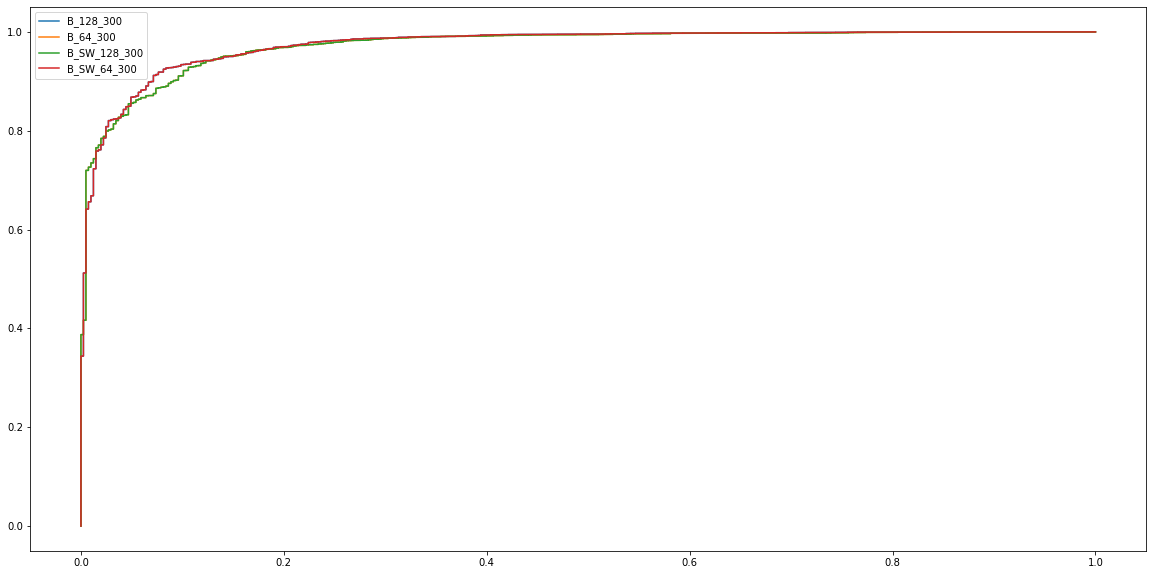

In [55]:
models = [(binary_128_300,'B_128_300'), 
          (binary_64_300,'B_64_300'),
          (binary_128_300SW,'B_SW_128_300'),
          (binary_64_300SW,'B_SW_64_300')]

fig, ax = plt.subplots(figsize=(20,10))
leg = []
for m in models:
    fpr, tpr, _ = ROC_NN(m[0], x_test, y_test)
    ax.plot(fpr, tpr)
    leg.append(m[1])
    
ax.legend(leg)

In [56]:
final_model_binary = binary_64_300SW

__Adjusting probability threshold__

In [57]:
fpr, tpr, thr = ROC_NN(final_model_binary, x_test, y_test)

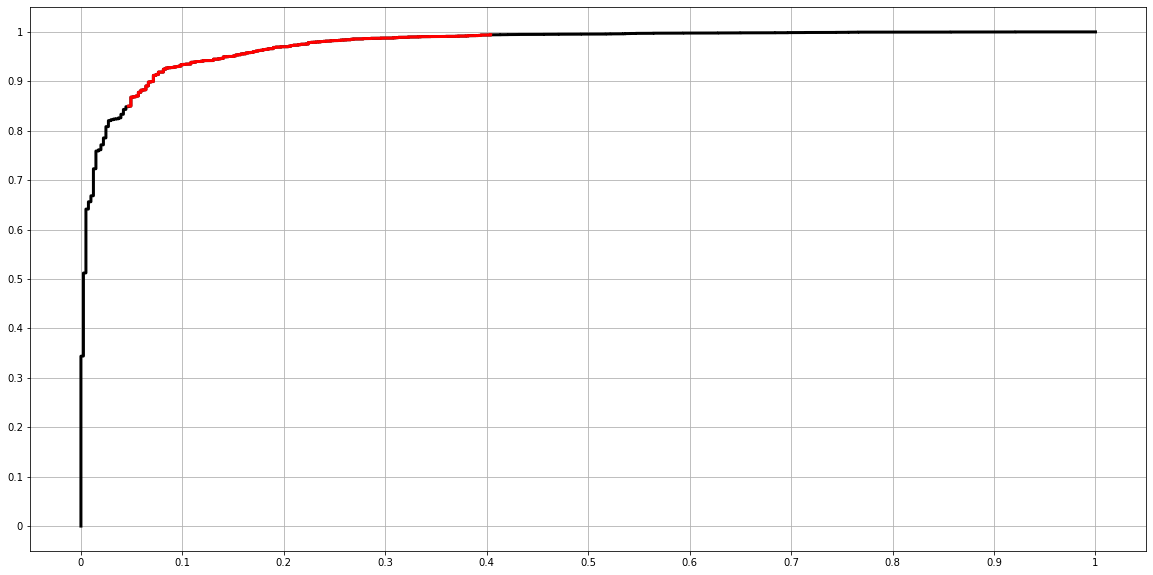

In [58]:
s, e = 1660, 1900
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(fpr, tpr, color='black', lw=3)
ax.plot(fpr[s:e], tpr[s:e], color='red', lw=3)
ax.grid(which='both')
plt.yticks(ticks=np.arange(0,1.1,0.1), labels=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.xticks(ticks=np.arange(0,1.1,0.1), labels=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.show()

In [59]:
#array for selecting optimal probability threshold - the first and the last value of the red line in the chart above
np.hstack([tpr.reshape(-1, 1),fpr.reshape(-1, 1), thr.reshape(-1, 1)])[[s,e]]

array([[0.84982415, 0.04679803, 0.99017835],
       [0.99413834, 0.41133005, 0.64865863]])

__The value of the threshold depends on the goal - whether precision or recall is more important, two thresholds were tested__

In [60]:
threshold = 0.99
y_pred_proba_pos = final_model_binary.predict(x_test)[:,1]
y_pred = np.where(y_pred_proba_pos > threshold, 1, 0)
print(confusion_matrix(y_test.argmax(1), y_pred))
print(classification_report(y_test.argmax(1), y_pred))
cm = confusion_matrix(y_test.argmax(1), y_pred)

print(f'number of reviews that are positive and are predicted as positive: {cm[1][1]}')
print(f'number of reviews that are negative and are predicted as negative: {cm[0][0]}')
print(f'number of reviews that are negative and are predicted as positive: {cm[0][1]}')
print(f'number of reviews that are positive and are predicted as negative: {cm[1][0]}')

[[ 386   20]
 [1266 7264]]
              precision    recall  f1-score   support

           0       0.23      0.95      0.38       406
           1       1.00      0.85      0.92      8530

    accuracy                           0.86      8936
   macro avg       0.62      0.90      0.65      8936
weighted avg       0.96      0.86      0.89      8936

number of reviews that are positive and are predicted as positive: 7264
number of reviews that are negative and are predicted as negative: 386
number of reviews that are negative and are predicted as positive: 20
number of reviews that are positive and are predicted as negative: 1266


In [61]:
threshold = 0.768
y_pred_proba_pos = final_model_binary.predict(x_test)[:,1]
y_pred = np.where(y_pred_proba_pos > threshold, 1, 0)
cm = confusion_matrix(y_test.argmax(1), y_pred)
print(cm)
print(classification_report(y_test.argmax(1), y_pred))
print(f'number of reviews that are positive and are predicted as positive: {cm[1][1]}')
print(f'number of reviews that are negative and are predicted as negative: {cm[0][0]}')
print(f'number of reviews that are negative and are predicted as positive: {cm[0][1]}')
print(f'number of reviews that are positive and are predicted as negative: {cm[1][0]}')

[[ 275  131]
 [  93 8437]]
              precision    recall  f1-score   support

           0       0.75      0.68      0.71       406
           1       0.98      0.99      0.99      8530

    accuracy                           0.97      8936
   macro avg       0.87      0.83      0.85      8936
weighted avg       0.97      0.97      0.97      8936

number of reviews that are positive and are predicted as positive: 8437
number of reviews that are negative and are predicted as negative: 275
number of reviews that are negative and are predicted as positive: 131
number of reviews that are positive and are predicted as negative: 93


__Misclassified reviews__

In [62]:
y_test.argmax(1)
data_evaluation=pd.DataFrame(np.hstack([y_test.argmax(1).reshape(-1, 1),y_pred.reshape(-1,1)]), columns=['true','predicted'])
idx = data_evaluation['true'] != data_evaluation['predicted']
data_evaluation['review'] = X_test

In [63]:
#false positive
data_evaluation[idx][data_evaluation.true == False].head(5)

<ipython-input-63-dae0dc0c1a20>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_evaluation[idx][data_evaluation.true == False].head(5)


,true,predicted,review
50,0,1,"is this what sonic has come to?! sega was proud to announce this new sonic game because it would redifine the sonic series. well...this game was a huge dissapointment to critics and fans alike.gameplay: at the most i would say its maybe a little below decent. sure, the speed makes it fun, but when you run into enemies and everything else, you have to slow down to go onto the next level.graphics: pretty good. not too next-generation, but there are lots of improvements from previous sonic games.story: i actually enjoyed part of silver's and sonic's story. the cutscenes were nicely made; perhaps the best part of the game.replay value: no replay value whatsoever, unless you want to unlock achivements for the xbox 360 version. otherwise you can beat the levels as fast as you like for absolutely no reward at all.overall: the game is a rent, not a buy. i'm a big sonic fan and only children who liked shadow the hedgehog would probably like this game to the fullest.read full review..."
90,0,1,no cables didnt get power cable
111,0,1,"so far, so good none"
118,0,1,great specs - sketchy touchscreen defective screens - the screens on this model are a bit of a hit and miss. certain areas of the screen do not register touch well and sliding does not always pick up properly. it is very frustrating playing some games or using applications with those sections of the screen.read full review...
162,0,1,this is not an ultra wide monitor it’s just a really nice standard monitor. it’s big. and it’s attractive. but it’s not an ultra wide as advertised. so disappointed.


In [64]:
#false negative
data_evaluation[idx][data_evaluation.true == True].head(5)

<ipython-input-64-9c1fc904ccb6>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_evaluation[idx][data_evaluation.true == True].head(5)


,true,predicted,review
71,1,0,bad onoff design the onoff switch is on the bottom of the screen frame. it is the light. there are other switches under the frame. no information was provided to explain their use.
97,1,0,iphone xs how long do you have to use?what percentage of battery life?
258,1,0,wifi wifi feature will not transfer pics to my macbook i called cannon and they have no answers how to fix the problem.
389,1,0,"read the fine print i received my headphones in a plain brown box even though they show a new boxed set that was supposedly just opened. i did not receive the cord to listen from my phone without bluetooth. not one page of instructions on how to use. thankfully my grandson had a pair and showed me how to very basically use. there is so much more to know than very basic. i ended up printing instructions online the actual directions for its use. it does tell you there are 180 pages of directions. i picked and chose what to print and still had to put paper in my printer 3 times to complete just what i felt like was absolutely needed for ultimate use. i would now purchase from someone that was selling everything i needed to use and operate. they do work as supposed to and love the item. just not happy it was not complete. it was represented as new, box opened.read full review..."
417,1,0,screen scratches verified purchase: yes condition: pre-owned sold by: breedproducts


__How does the model predict a sentiment of a neutral review__

In [65]:
reviews_neutral = data_preprocessed[data_preprocessed.rating == 1].review.values.tolist()
neutral_to_predict = reviews_neutral[100:110]

neutral_to_predict_tokenized = preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(neutral_to_predict), maxlen=maxlen)
y_pred_neutral = final_model_binary.predict(neutral_to_predict_tokenized)

df = pd.DataFrame(data=reviews_neutral[100:110], columns=['review'])
df['predicted'] = y_pred_neutral.argmax(1)
df

,review,predicted
0,it’s a great game!!! verified purchase: yes condition: new sold by: nerdynero,1
1,great game my son loves this game fast shipping a,1
2,super smash bros. good game.,1
3,love it i loved playing this game on the gamecube and so it makes me happy playing it.,1
4,happy the game works great!,1
5,super smash bros ultimate it is fun but is very hard to get the characters so maybe next time they can tell us how to get characters,1
6,video game great game,1
7,game is in working condition woks great!,1
8,good game my son loves this game. he's plays every chance he gets.,1
9,best game good game,1


## 2. Multiclass classification

In [66]:
def model_summary(model, X_test, y_test):
    """
    Function that prints classification report and confusion matrix for a given model
    """
    
    y_pred = model.predict(X_test).argmax(1)
    print('\nconfusion matrix\n', confusion_matrix(y_test.argmax(1), y_pred))

    print('\nclassification report\n',classification_report(y_test.argmax(1), y_pred))

In [70]:
data.rating.replace({3:1, 1:2, 0:0}, inplace=True)

In [72]:
X = data.review.values.tolist()
y = data.loc[:, 'rating'].astype('float')
y = to_categorical(y, num_classes=3)
X_train_MC, X_test_MC, y_train_MC, y_test_MC = train_test_split(X, y, test_size=0.2, stratify=y, random_state=100)

In [73]:
#top 10000 words are considered
tokenizer_MC = Tokenizer(num_words=10000)
tokenizer_MC.fit_on_texts(X_train_MC)
sequences_train_MC = tokenizer_MC.texts_to_sequences(X_train_MC)
sequences_test_MC = tokenizer_MC.texts_to_sequences(X_test_MC)

maxlen=200
x_train_MC = preprocessing.sequence.pad_sequences(sequences_train_MC, maxlen=maxlen)
x_test_MC = preprocessing.sequence.pad_sequences(sequences_test_MC, maxlen=maxlen)

word_index_MC = tokenizer_MC.word_index

In [74]:
embedding_dim = 300
max_words=10000

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index_MC.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [75]:
load = True

In [77]:
if not load:
    early_stopping = EarlyStopping(patience=4, monitor='val_loss', restore_best_weights=True)
    
    #model without sample weights
    model = Sequential()
    model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
    model.add(Bidirectional(LSTM(256, return_sequences=False)))
    model.add(Dense(256, 'tanh'))
    model.add(Dense(64, 'tanh'))
    model.add(Dense(3, 'softmax'))

    #using the pretrained embeddings
    model.layers[0].set_weights([embedding_matrix])
    model.layers[0].trainable = False

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
    model.summary()
    model.fit(x_train_MC, y_train_MC, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])
    
    
    model.save(f'multiclass{str(date.today())}.h5')

#-------------------------------------------model with sample weights------------------------------------------------------  
    sample_weights = np.where(y_train_MC[:,2] == 1., 1, 20) 

    modelSW = Sequential()
    modelSW.add(Embedding(max_words, embedding_dim, input_length=maxlen))
    modelSW.add(Bidirectional(LSTM(256, return_sequences=False)))
    modelSW.add(Dense(256, 'tanh'))
    modelSW.add(Dense(64, 'tanh'))
    modelSW.add(Dense(3, 'softmax'))

    #using the pretrained embeddings
    modelSW.layers[0].set_weights([embedding_matrix])
    modelSW.layers[0].trainable = False

    modelSW.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
    modelSW.summary()
    modelSW.fit(x_train_MC, y_train_MC, epochs=100, batch_size=32, 
              validation_split=0.2, 
              callbacks=[early_stopping], sample_weight=sample_weights)

    modelSW.save(f'multiclassSW{str(date.today())}.h5')


else:
    #word embeddings dimension 300 with sample weights
    MC_300SW = load_model('models/NN_MC_300SW.h5')

    #word embeddings dimension 300 without sample weights    
    MC_300_2 = load_model('models/NN_MC_300_2.h5')

    #word embeddings dimension 300 without sample weights with more neurons
    MC_300SW_2 = load_model('models/NN_MC_300SW_2.h5')

    #word embeddings dimension 100 without sample weights    
    MC_300 = load_model('models/NN_MC_300.h5')

In [78]:
modelsMC = [(MC_300,'MC_300'), 
            (MC_300_2,'MC_300_2'),
            (MC_300SW,'MC_300SW'),
            (MC_300SW_2,'MC_300SW_2')]

for m in modelsMC:
    print(f'model {m[1]}')
    model_summary(m[0], x_test_MC, y_test_MC)
    print()

model models/MC_300

confusion matrix
 [[  55   13  338]
 [  14   12  262]
 [ 111   44 8375]]

classification report
               precision    recall  f1-score   support

           0       0.31      0.14      0.19       406
           1       0.17      0.04      0.07       288
           2       0.93      0.98      0.96      8530

    accuracy                           0.92      9224
   macro avg       0.47      0.39      0.40      9224
weighted avg       0.88      0.92      0.90      9224


model models/MC_300_2

confusion matrix
 [[  84    1  321]
 [  35    1  252]
 [ 234    7 8289]]

classification report
               precision    recall  f1-score   support

           0       0.24      0.21      0.22       406
           1       0.11      0.00      0.01       288
           2       0.94      0.97      0.95      8530

    accuracy                           0.91      9224
   macro avg       0.43      0.39      0.39      9224
weighted avg       0.88      0.91      0.89      9224


# Summary

The neutral network models performs worser than the SVC model.